In [ ]:
# local pc --> colab 파일 업로드
#  여러개 동시 선택 가능 해야 됨
from google.colab import files

uploaded = files.upload()
for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))

# cifar 10으로 validation accuracy 높이기
## 1. pytorch
-  https://github.com/kuangliu/pytorch-cifar ==> pytorch 코드가 있는데 모델별로 92~95%

- pytorch tutorial의 간단한 모델로 하면, val acc = 65%정도 나온다. https://tutorials.pytorch.kr/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py

- transfer learning: pretrained weight를 고정하면 train이 잘 안된다. 고정하지 않아야 한다.
- vgg16, resnet18로 data augmentation 적용해서 train하면 val acc=83~85%정도 나온다. vgg16은 lr=0.00005로 해야 한다.
    * https://github.com/kuangliu/pytorch-cifar --> vgg16(BN이 포함되어 있다)으로 MultiStepLR, 344epoch(190분 소요) . 93.8%
    * pytorch vgg16(lr=0.00005): 100 epoch train acc = 98%, test acc = 83% 정도 나온다. ==> vgg는 모델이 커서 느리다.
    * pytorch resnet18 + MultiStepLR:
        - MultiStepLR(optimizer,milestones=[150,300,450],gamma=0.1)
        - 150 epoch 전에 정체되다 150넘어서 lr이 조정되니 77% --> 84%
        - 214 epoch에 85.5% 
    * pytorch resnet18 + torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,  mode = 'max',threshold_mode='abs',threshold=0.001, factor=0.6,patience=10, min_lr=0.0001,verbose=True)
        - 216 epoch에 87.6% 이후, 더 이상 개선이 안됨
    * resnet18(kuangliu)+ReduceLROnPlateau: 모델 구조가 좀 다르다. 95.2%(150 epoch)
    * pytorch vgg16_bn+MultiStepLR: 168 epoch, 92.9%

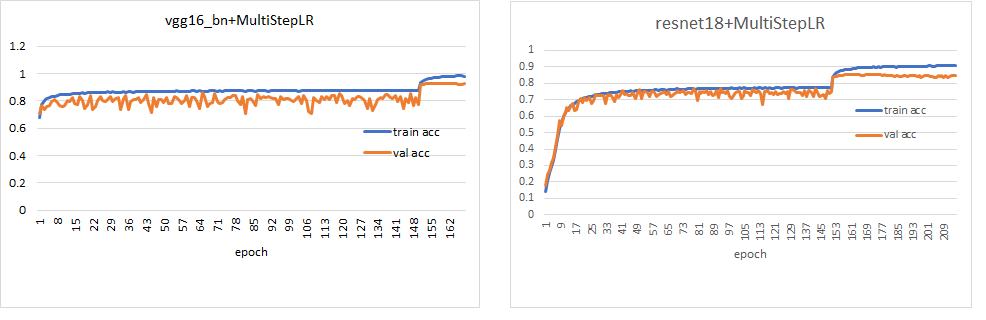



In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torchvision.models as models

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
#transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),  # padding 후, 지정한 크기로 잘라낸다. https://chloes-dl.com/2019/11/13/pytorch101-data-preprocessing-and-augmentation-part-1/
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])



batch_size = 128
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,download=True, transform=transform_train)  # torchvision.datasets.cifar.CIFAR10
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print(f'train data: {len(trainset)}, test data: {len(testset)}')
print(f'# of mini-batch: {len(trainset)//batch_size}')

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
train data: 50000, test data: 10000
# of mini-batch: 390


In [ ]:
cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}


class x_VGG(nn.Module):  # beginner-blitz-cifar10-tutorial-py에 있는 VGG
    def __init__(self, vgg_name):
        super(x_VGG, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Linear(512, 10)

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)

class MyVGG(nn.Module):
    def __init__(self):
        super(MyVGG, self).__init__()
        mode = 2
        self.flatten = nn.Flatten()
        if mode ==1:
            self.vgg = models.vgg16_bn(pretrained=True,progress=True)
            self.fc = nn.Linear(1000,10)
        else:
            self.vgg = models.vgg16_bn(pretrained=True,progress=True).features
            self.fc = nn.Linear(512,10)
    def forward(self, x):
        x = self.vgg(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

my_resnet = models.resnet18(pretrained=True)
my_resnet.fc = nn.Linear(my_resnet.fc.in_features,10)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model_selection = 1  # 1: resnet, 2: vgg, 3. x_VGG

if model_selection ==1:
    net = my_resnet
elif model_selection ==2:
    net = MyVGG()   # lr=0.00005 또는 Adam말고 SGD로 해야됨.
else:
    net = x_VGG('VGG16')


net.to(device)   
criterion = nn.CrossEntropyLoss()

if model_selection ==1:
    #optimizer = optim.SGD(net.parameters(), lr=0.001)
    optimizer = optim.SGD(net.parameters(), lr=0.1,momentum=0.9, weight_decay=5e-4)  # 
    #scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,milestones=[150,300,450],gamma=0.1)  # train이 정체되다 150 epoch을 지나면서, lr이 바뀌니 확 좋아짐.
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,  mode = 'max',threshold_mode='abs',threshold=0.001, factor=0.6,patience=10, min_lr=0.0001,verbose=True)


elif model_selection ==2:
    #optimizer = optim.Adam(net.parameters(), lr=0.0001,betas=(0.5, 0.9))
    optimizer = optim.SGD(net.parameters(), lr=0.1,momentum=0.9, weight_decay=5e-4)  # 
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,milestones=[150,300,450],gamma=0.1)

else:
    optimizer = optim.SGD(net.parameters(), lr=0.1,momentum=0.9, weight_decay=5e-4)  # for x_VGG
    #scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,milestones=[150,300,450],gamma=0.1)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


In [ ]:
s_time = time.time()
best_acc = 0
best_duration=0
for epoch in range(400):  # loop over the dataset multiple times

    running_loss = []
    acc = 0
    total = 0
    net.train()
    for i, data in enumerate(trainloader):
        # get the inputs
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        _, pred = outputs.max(axis=-1)
        acc  += (pred==labels).float().sum().item()
        total += len(labels)


        # print statistics
        running_loss.append(loss.item())
    print('[epoch: %d] loss: %.3f, train acc: %.3f elapsed: %.2f' % (epoch + 1, np.mean(running_loss), acc/total , time.time()-s_time),end="\t" )
    #scheduler.step()
    acc = 0
    total=0
    net.eval()
    with torch.no_grad():
        for i, data in enumerate(testloader):
            inputs, labels = data
            inputs = inputs.to(device)
            outputs = net(inputs)
            
            _, pred = outputs.max(axis=-1)
            acc  += (pred.cpu()==labels).float().sum().item()
            total += len(labels)
    if acc/total > best_acc:
        print('test acc: %.3f, best: %.3f ===== new best ' % (acc/total,best_acc ))
        best_acc = acc/total
        best_duration = 0
    else:
        best_duration += 1
        print('test acc: %.3f, best: %.3f, best duration: %d ' % (acc/total,best_acc, best_duration ) )
    scheduler.step(acc/total)


[epoch: 1] loss: 0.958, train acc: 0.678 elapsed: 28.92
test acc: 0.709, bsest: 0.000 
[epoch: 2] loss: 0.667, train acc: 0.776 elapsed: 60.76
test acc: 0.767, bsest: 0.709 
[epoch: 3] loss: 0.580, train acc: 0.807 elapsed: 93.43
test acc: 0.739, bsest: 0.767 
[epoch: 4] loss: 0.545, train acc: 0.817 elapsed: 126.05
test acc: 0.760, bsest: 0.767 
[epoch: 5] loss: 0.515, train acc: 0.827 elapsed: 158.48
test acc: 0.766, bsest: 0.767 
[epoch: 6] loss: 0.498, train acc: 0.836 elapsed: 191.10
test acc: 0.795, bsest: 0.767 
[epoch: 7] loss: 0.494, train acc: 0.835 elapsed: 223.65
test acc: 0.811, bsest: 0.795 
[epoch: 8] loss: 0.483, train acc: 0.838 elapsed: 256.18
test acc: 0.791, bsest: 0.811 
[epoch: 9] loss: 0.468, train acc: 0.846 elapsed: 288.81
test acc: 0.767, bsest: 0.811 
[epoch: 10] loss: 0.470, train acc: 0.844 elapsed: 321.49
test acc: 0.763, bsest: 0.811 
[epoch: 11] loss: 0.464, train acc: 0.846 elapsed: 354.09
test acc: 0.767, bsest: 0.811 
[epoch: 12] loss: 0.453, train ac

KeyboardInterrupt: ignored

In [ ]:
# test accuracy
correct = 0
total = 0
labels_all = []
predicted_all = []
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images.to(device))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.cpu() == labels).sum().item()

        labels_all.extend(labels.numpy())
        predicted_all.extend(predicted.cpu().numpy())

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
confusion_matrix = confusion_matrix(labels_all, predicted_all)  # numpy array
sns.heatmap(confusion_matrix, xticklabels=classes, yticklabels=classes, annot=True, fmt='g',cmap="YlGnBu")  # cmap="Blues"
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.tight_layout()
plt.show()

### torchsummay로 모델 구조 살펴보기
- pip install torchsummary

In [ ]:
from torchsummary import summary
#my_resnet.to('cpu')

net = MyVGG()
summary(net, input_size=(3, 32, 32),device='cpu')

## 2. Tensorflow
- tensorflow는 resnet18을 제공하지 않는다. resnet50이 resnet중에는 제일 작은 모델
- resnet.preprocess_input은 별 효과 없다. 자체적인 augmentation이 낫다.
- resnet50이 규모가 있기 때문에, classifier의 fc에 dropout을 적용하는 것이 낫다.
- clipnorm은 별 효과 없다.

    - resnet50: 100 epoch, train acc = 99%, val acc = 79%~80%
    - resnet18: 200 epoch, train acc = 95%, val acc = 80%

- pytorch만큼 성능이 안 나옴. 개선책
    * https://appliedmachinelearning.blog/2018/03/24/achieving-90-accuracy-in-object-recognition-task-on-cifar-10-dataset-with-keras-convolutional-neural-networks/ 여기 있는 좀 더 간단한 구조로 하면 90%까지 나옴
    * resnet 모델 수정 1: 초반의 7x7을 3x3으로 수정하고, maxpooling 제거: 87.52%(100 epoch)
    * kuangliu의 pytorch 코드를 Tensorflow 코드로 동일하게 변환

In [10]:
import tensorflow as tf
from tensorflow.keras.applications import resnet
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# https://github.com/calmisential/TensorFlow2.0_ResNet/tree/master/models

NUM_CLASSES = 10

class BasicBlock(tf.keras.layers.Layer):

    def __init__(self, filter_num, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(filters=filter_num,
                                            kernel_size=(3, 3),
                                            strides=stride,
                                            padding="same",use_bias=False)
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.conv2 = tf.keras.layers.Conv2D(filters=filter_num,
                                            kernel_size=(3, 3),
                                            strides=1,
                                            padding="same",use_bias=False)
        self.bn2 = tf.keras.layers.BatchNormalization()
        if stride != 1:
            self.downsample = tf.keras.Sequential()
            self.downsample.add(tf.keras.layers.Conv2D(filters=filter_num,
                                                       kernel_size=(1, 1),
                                                       strides=stride,use_bias=False))
            self.downsample.add(tf.keras.layers.BatchNormalization())
        else:
            self.downsample = lambda x: x

    def call(self, inputs, training=None, **kwargs):
        residual = self.downsample(inputs)

        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = tf.nn.relu(x)
        x = self.conv2(x)
        x = self.bn2(x, training=training)

        output = tf.nn.relu(tf.keras.layers.add([residual, x]))

        return output


class BottleNeck(tf.keras.layers.Layer):
    def __init__(self, filter_num, stride=1):
        super(BottleNeck, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(filters=filter_num,
                                            kernel_size=(1, 1),
                                            strides=1,
                                            padding='same',use_bias=False)
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.conv2 = tf.keras.layers.Conv2D(filters=filter_num,
                                            kernel_size=(3, 3),
                                            strides=stride,
                                            padding='same',use_bias=False)
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.conv3 = tf.keras.layers.Conv2D(filters=filter_num * 4,
                                            kernel_size=(1, 1),
                                            strides=1,
                                            padding='same',use_bias=False)
        self.bn3 = tf.keras.layers.BatchNormalization()

        self.downsample = tf.keras.Sequential()
        self.downsample.add(tf.keras.layers.Conv2D(filters=filter_num * 4,
                                                   kernel_size=(1, 1),
                                                   strides=stride,use_bias=False))
        self.downsample.add(tf.keras.layers.BatchNormalization())

    def call(self, inputs, training=None, **kwargs):
        residual = self.downsample(inputs)

        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = tf.nn.relu(x)
        x = self.conv2(x)
        x = self.bn2(x, training=training)
        x = tf.nn.relu(x)
        x = self.conv3(x)
        x = self.bn3(x, training=training)

        output = tf.nn.relu(tf.keras.layers.add([residual, x]))

        return output


def make_basic_block_layer(filter_num, blocks, stride=1):
    res_block = tf.keras.Sequential()
    res_block.add(BasicBlock(filter_num, stride=stride))

    for _ in range(1, blocks):
        res_block.add(BasicBlock(filter_num, stride=1))

    return res_block


def make_bottleneck_layer(filter_num, blocks, stride=1):
    res_block = tf.keras.Sequential()
    res_block.add(BottleNeck(filter_num, stride=stride))

    for _ in range(1, blocks):
        res_block.add(BottleNeck(filter_num, stride=1))

    return res_block
class ResNetTypeI(tf.keras.Model):
    def __init__(self, layer_params):
        super(ResNetTypeI, self).__init__()

        self.conv1 = tf.keras.layers.Conv2D(filters=64,
                                            kernel_size=(7, 7),
                                            strides=2,
                                            padding="same",use_bias=False)
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.pool1 = tf.keras.layers.MaxPool2D(pool_size=(3, 3),
                                               strides=2,
                                               padding="same")

        self.layer1 = make_basic_block_layer(filter_num=64,
                                             blocks=layer_params[0])
        self.layer2 = make_basic_block_layer(filter_num=128,
                                             blocks=layer_params[1],
                                             stride=2)
        self.layer3 = make_basic_block_layer(filter_num=256,
                                             blocks=layer_params[2],
                                             stride=2)
        self.layer4 = make_basic_block_layer(filter_num=512,
                                             blocks=layer_params[3],
                                             stride=2)

        self.avgpool = tf.keras.layers.GlobalAveragePooling2D()
        self.fc = tf.keras.layers.Dense(units=NUM_CLASSES, activation=None)

    def call(self, inputs, training=None, mask=None):
        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = tf.nn.relu(x)
        x = self.pool1(x)
        x = self.layer1(x, training=training)
        x = self.layer2(x, training=training)
        x = self.layer3(x, training=training)
        x = self.layer4(x, training=training)
        x = self.avgpool(x)
        output = self.fc(x)

        return output


class ResNetTypeII(tf.keras.Model):
    def __init__(self, layer_params):
        super(ResNetTypeII, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(filters=64,
                                            kernel_size=(7, 7),
                                            strides=2,
                                            padding="same",use_bias=False)
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.pool1 = tf.keras.layers.MaxPool2D(pool_size=(3, 3),
                                               strides=2,
                                               padding="same")

        self.layer1 = make_bottleneck_layer(filter_num=64,
                                            blocks=layer_params[0])
        self.layer2 = make_bottleneck_layer(filter_num=128,
                                            blocks=layer_params[1],
                                            stride=2)
        self.layer3 = make_bottleneck_layer(filter_num=256,
                                            blocks=layer_params[2],
                                            stride=2)
        self.layer4 = make_bottleneck_layer(filter_num=512,
                                            blocks=layer_params[3],
                                            stride=2)

        self.avgpool = tf.keras.layers.GlobalAveragePooling2D()
        self.fc = tf.keras.layers.Dense(units=NUM_CLASSES, activation=None)

    def call(self, inputs, training=None, mask=None):
        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = tf.nn.relu(x)
        x = self.pool1(x)
        x = self.layer1(x, training=training)
        x = self.layer2(x, training=training)
        x = self.layer3(x, training=training)
        x = self.layer4(x, training=training)
        x = self.avgpool(x)
        output = self.fc(x)

        return output


def resnet_18():
    return ResNetTypeI(layer_params=[2, 2, 2, 2])


def resnet_34():
    return ResNetTypeI(layer_params=[3, 4, 6, 3])


def resnet_50():
    return ResNetTypeII(layer_params=[3, 4, 6, 3])


def resnet_101():
    return ResNetTypeII(layer_params=[3, 4, 23, 3])


def resnet_152():
    return ResNetTypeII(layer_params=[3, 8, 36, 3])


class CommonLayers (tf.keras.Model):
    def __init__ (self, flag = 0):
        super().__init__()
        self.flag = flag
        if flag != 0:
            self.conv = tf.keras.layers.Conv2D(filters = flag, kernel_size = 3, padding="SAME", kernel_initializer='glorot_uniform', use_bias=False)
        self.bn = tf.keras.layers.BatchNormalization ()

    def call (self, inputs):
        if self.flag == 0:
            return tf.nn.relu (self.bn (inputs))
        else:
            return tf.nn.relu (self.bn (self.conv (inputs)))





In [3]:
def plot_history(history):
    """Plots accuracy/loss for training/validation set as a function of the epochs

        :param history: Training history of model
        :return:
    """

    fig, axs = plt.subplots(1,2)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()
def my_preprocessing(image,label):

    image = image/255.   # tf.image.convert_image_dtype는 정수가 들어 왔을 때, 0~1로 변환한다. 넘어온 image에는 resize되면서 0~255사이의 float 값이 들어 있다.

    image = tf.image.random_flip_left_right(image)  # 확률 50%로 고정되어 있음.
    image = tf.image.random_brightness(image, max_delta=0.3)
    image = tf.image.random_saturation(image, lower=0.5, upper=1.5)  # 채도 조절
    # random crop
    shape = tf.shape(image)  # batch size 알아내기
    image = tf.image.resize_with_pad(image, 40,40)
    image = tf.image.random_crop(image,(shape[0],32,32,3))

    image = tf.clip_by_value(image, 0.0, 1.0)

    return image, label

def my_preprocessing2(image,label):

    image = image/255.   # tf.image.convert_image_dtype는 정수가 들어 왔을 때, 0~1로 변환한다. 넘어온 image에는 resize되면서 0~255사이의 float 값이 들어 있다.
    # random crop
    shape = tf.shape(image)  # batch size 알아내기
    image = tf.image.resize_with_pad(image, 36,36)
    image = tf.image.random_crop(image,(shape[0],32,32,3))
    image = tf.image.random_flip_left_right(image)

    image = tf.clip_by_value(image, 0.0, 1.0)
    

    return image, label
def normalize(image,label):
    return (image - [0.4914, 0.4822, 0.4465] )/ [0.2023, 0.1994, 0.2010], label

def pad_and_random_crop(image):
    image = tf.image.resize_with_pad(image, 36,36)
    image = tf.image.random_crop(image,(32,32,3))   
    return image


In [32]:
model_selection = 3   # 1: resnet50, 2: resnet18

if model_selection==1:
    base_model = resnet.ResNet50(weights='imagenet',include_top=False,input_shape=(32,32,3))  # weights=None, weights='imagenet'
    base_model.trainable = True

    my_resnet = tf.keras.Sequential([ base_model,tf.keras.layers.GlobalAveragePooling2D(),tf.keras.layers.Dropout(0.5),tf.keras.layers.Dense(10)])
elif model_selection==2:
    my_resnet = resnet_18()
else:
    base_model = ResNetX18()
    my_resnet = tf.keras.Sequential([ base_model,tf.keras.layers.Dense(10)])

In [31]:
# data loading
batch_size = 128

DATA_MODE = 1 # 1: tf.data.Dataset  2: tf.ImageDataGenerator

if DATA_MODE==2:
    print('Data from  from_tensor_slices')
    resnet_pre = False

    if resnet_pre:
        (x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()  # numpy array 
        print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)  # (50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)
        train_dataset = tf.data.Dataset.from_tensor_slices((tf.cast(x_train, tf.float32), tf.cast(y_train.reshape(-1),tf.int64)))
        train_dataset = train_dataset.map(lambda a,b: (resnet.preprocess_input(a), b))

        train_dataset = train_dataset.shuffle(1000).batch(batch_size)


        valid_dataset = tf.data.Dataset.from_tensor_slices((tf.cast(x_test, tf.float32), tf.cast(y_test.reshape(-1),tf.int64)))
        valid_dataset = valid_dataset.map(lambda a,b: (resnet.preprocess_input(a), b))
        valid_dataset = valid_dataset.batch(batch_size)

    else:
        (x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()  # numpy array 
        print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)  # (50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)
        train_dataset = tf.data.Dataset.from_tensor_slices((tf.cast(x_train, tf.float32), tf.cast(y_train.reshape(-1),tf.int64)))

        train_dataset = train_dataset.shuffle(1000).batch(batch_size)
        train_dataset = train_dataset.map(my_preprocessing2)
        train_dataset = train_dataset.map(normalize)

        valid_dataset = tf.data.Dataset.from_tensor_slices((tf.cast(x_test/255., tf.float32), tf.cast(y_test.reshape(-1),tf.int64)))

        valid_dataset = valid_dataset.batch(batch_size)
        valid_dataset = valid_dataset.map(normalize)
else:
    print('Data from  ImageDataGenerator')
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()  # numpy array 
    print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)  # (50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)

    train_datagen = ImageDataGenerator(rescale=1./255,
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        preprocessing_function=None,
        )
    train_dataset = train_datagen.flow(x_train, y_train.reshape(-1), batch_size=batch_size,shuffle=True)

    valid_datagen = ImageDataGenerator(rescale=1./255)
    valid_dataset = valid_datagen.flow(x_test, y_test.reshape(-1), batch_size=batch_size)    


Data from  ImageDataGenerator
(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


In [33]:
initial_learning_rate = 0.1
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
                            monitor='val_accuracy',  # val loss를 기준으로...
                            factor=0.6,          # callback 호출시 lr = factor*lr
                            patience=10,         # patience epoch동안 monitor값이 좋아지지 않으면 callback 작동
                            cooldown=0,         # lr이 변경된 후, cooldonw동안에는 callback이 작동 안 한다.
                            min_lr=0.0001, 
                            verbose = 1,min_delta=0.001)



optimizer = tf.keras.optimizers.SGD(learning_rate=initial_learning_rate,momentum=0.9)  # lr or learning_rate

my_resnet.compile(optimizer,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])
model_filename = "Epoch-{epoch:02d}-{val_accuracy:.4f}"
checkpoint_path = os.path.join('models/', model_filename)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,save_weights_only=True,verbose=1,mode='auto',save_best_only=True,monitor='val_accuracy')

In [ ]:
history = my_resnet.fit(train_dataset,epochs=200,validation_data=valid_dataset,validation_freq=1, verbose=1,callbacks=[cp_callback,lr_callback],initial_epoch=111)

Epoch 1/200
391/391 [==============================] - 46s 112ms/step - loss: 3.1407 - accuracy: 0.1752 - val_loss: 2.1312 - val_accuracy: 0.2606

Epoch 00001: val_accuracy improved from -inf to 0.26060, saving model to models/Epoch-01-0.2606
Epoch 2/200
391/391 [==============================] - 45s 115ms/step - loss: 1.6244 - accuracy: 0.3941 - val_loss: 2.0992 - val_accuracy: 0.3371

Epoch 00002: val_accuracy improved from 0.26060 to 0.33710, saving model to models/Epoch-02-0.3371
Epoch 3/200
391/391 [==============================] - 46s 118ms/step - loss: 1.4166 - accuracy: 0.4800 - val_loss: 1.7199 - val_accuracy: 0.4453

Epoch 00003: val_accuracy improved from 0.33710 to 0.44530, saving model to models/Epoch-03-0.4453
Epoch 4/200
391/391 [==============================] - 48s 122ms/step - loss: 1.2180 - accuracy: 0.5557 - val_loss: 1.2162 - val_accuracy: 0.5846

Epoch 00004: val_accuracy improved from 0.44530 to 0.58460, saving model to models/Epoch-04-0.5846
Epoch 5/200
391/391

## 3. Tensorflow 중간규모 Model
- https://appliedmachinelearning.blog/2018/03/24/achieving-90-accuracy-in-object-recognition-task-on-cifar-10-dataset-with-keras-convolutional-neural-networks/
- 여기 keras코드를 tensorflow코드로 재구성
- ImageDataGenerator로 data augmentation

- lr=0.001로 시작해서,213 epoch 이후, val acc가 더 이상 좋아지지 않아(88.59%), lr=0.0001로 train 이어가기
- 288 epoch에 90.53%

In [24]:
import tensorflow as tf
from tensorflow.keras.applications import resnet
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

In [ ]:
class MyModel(tf.keras.Model):
    def __init__(self,input_shape):
        super(MyModel, self).__init__()

        weight_decay = 1e-4

        self.model = tf.keras.models.Sequential()
        self.model.add(tf.keras.layers.Conv2D(32, (3,3), padding='same', kernel_regularizer=tf.keras.regularizers.l2(weight_decay), input_shape=input_shape))
        self.model.add(tf.keras.layers.BatchNormalization())
        self.model.add(tf.keras.layers.ELU())
        
        self.model.add(tf.keras.layers.Conv2D(32, (3,3), padding='same', kernel_regularizer=tf.keras.regularizers.l2(weight_decay)))
        self.model.add(tf.keras.layers.BatchNormalization())
        self.model.add(tf.keras.layers.ELU())        
        
        self.model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
        self.model.add(tf.keras.layers.Dropout(0.2))      


        self.model.add(tf.keras.layers.Conv2D(64, (3,3), padding='same', kernel_regularizer=tf.keras.regularizers.l2(weight_decay)))
        self.model.add(tf.keras.layers.BatchNormalization())
        self.model.add(tf.keras.layers.ELU())
        
        self.model.add(tf.keras.layers.Conv2D(64, (3,3), padding='same', kernel_regularizer=tf.keras.regularizers.l2(weight_decay)))
        self.model.add(tf.keras.layers.BatchNormalization())
        self.model.add(tf.keras.layers.ELU())        
        
        self.model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
        self.model.add(tf.keras.layers.Dropout(0.3))    


        self.model.add(tf.keras.layers.Conv2D(128, (3,3), padding='same', kernel_regularizer=tf.keras.regularizers.l2(weight_decay)))
        self.model.add(tf.keras.layers.BatchNormalization())
        self.model.add(tf.keras.layers.ELU())
        
        self.model.add(tf.keras.layers.Conv2D(128, (3,3), padding='same', kernel_regularizer=tf.keras.regularizers.l2(weight_decay)))
        self.model.add(tf.keras.layers.BatchNormalization())
        self.model.add(tf.keras.layers.ELU())        
        
        self.model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
        self.model.add(tf.keras.layers.Dropout(0.4))   

        self.model.add(tf.keras.layers.Flatten())


        self.built = True  # summary가 제대로 작동한다.

    def call(self,x,training=None):  # training의 default 값으로 None이 좋다(Ture/False보다)
        output = self.model(x)
        return output

In [25]:
batch_size = 128

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()  # numpy array 
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)  # (50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)

train_datagen = ImageDataGenerator(rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    )
train_dataset = train_datagen.flow(x_train, y_train.reshape(-1), batch_size=batch_size,shuffle=True)

valid_datagen = ImageDataGenerator(rescale=1./255)
valid_dataset = valid_datagen.flow(x_test, y_test.reshape(-1), batch_size=batch_size)

(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


In [28]:
# base_model = MyModel(input_shape=(32,32,3))
# model = tf.keras.Sequential([ base_model,tf.keras.layers.Dense(10)])

base_model = ResNetX18()
model = tf.keras.Sequential([ base_model,tf.keras.layers.Dense(10)])

In [29]:
initial_learning_rate = 0.1
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
                            monitor='val_accuracy',  # val loss를 기준으로...
                            factor=0.6,          # callback 호출시 lr = factor*lr
                            patience=10,         # patience epoch동안 monitor값이 좋아지지 않으면 callback 작동
                            cooldown=0,         # lr이 변경된 후, cooldonw동안에는 callback이 작동 안 한다.
                            min_lr=0.0001, 
                            verbose = 1,min_delta=0.001)
es_callback = tf.keras.callbacks.EarlyStopping(
                            monitor="val_accuracy",
                            min_delta=0.003,  # 이 값 이상으로 변화되어야 향상으로 인정.
                            patience=40,
                            verbose=1,
                            mode="auto",
                            baseline=None,
                            restore_best_weights=True,  # stop될때 마지막이 아닌, best weight로 복원
                        )




optimizer = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate, clipnorm=0.5)  # lr or learning_rate

model.compile(optimizer,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])
model_filename = "Epoch-{epoch:02d}-{val_accuracy:.4f}"
checkpoint_path = os.path.join('models/', model_filename)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,save_weights_only=True,verbose=1,mode='auto',save_best_only=True,monitor='val_accuracy')

In [30]:
history = model.fit(train_dataset,epochs=400,steps_per_epoch=len(x_train)/batch_size,validation_data=valid_dataset,validation_freq=1, verbose=1,callbacks=[cp_callback,lr_callback],initial_epoch=0)

Epoch 1/400
390/390 [==============================] - 48s 114ms/step - loss: 3.7592 - accuracy: 0.1604 - val_loss: 2.4506 - val_accuracy: 0.1491

Epoch 00001: val_accuracy improved from -inf to 0.14910, saving model to models/Epoch-01-0.1491
Epoch 2/400
 65/390 [===>..........................] - ETA: 35s - loss: 1.8685 - accuracy: 0.2622

KeyboardInterrupt: ignored

## 4. pytorch로된 kuangliu의 코드를 tesorflow 코드로 동일하게 변환

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
from functools import partial


In [7]:
class BasicBlockX(tf.keras.Model): # 논문의 resnet구조로 다르다.
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlockX, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(planes,kernel_size=3, strides=stride, padding="SAME", use_bias=False)
        
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.conv2 = tf.keras.layers.Conv2D(planes,kernel_size=3, strides=1, padding="SAME", use_bias=False)
        self.bn2 = tf.keras.layers.BatchNormalization()

        self.shortcut = tf.keras.models.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut.add(tf.keras.layers.Conv2D(self.expansion*planes,kernel_size=1, strides=stride, padding="SAME", use_bias=False))
            self.shortcut.add(tf.keras.layers.BatchNormalization())

    def call(self, x, training=None):
        out = tf.nn.relu(self.bn1(self.conv1(x),training))
        out = self.bn2(self.conv2(out),training)
        out += self.shortcut(x,training)
        out = tf.nn.relu(out)
        return out


class ResNetX(tf.keras.Model):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNetX, self).__init__()
        self.in_planes = 64

        self.conv1 = tf.keras.layers.Conv2D(64,kernel_size=3, strides=1, padding="SAME", use_bias=False) 
        self.bn1 = tf.keras.layers.BatchNormalization()
        
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        
        self.flatten = tf.keras.layers.Flatten()
        self.linear = tf.keras.layers.Dense(units=num_classes)
        
        self.built = True

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return tf.keras.models.Sequential(layers)
    def build(self,input_shape):
        #super(ResNetX, self).build(input_shape)
        super().build(input_shape)
    
    def call(self, x,training=None):
        out = tf.nn.relu(self.bn1(self.conv1(x),training))
        out = self.layer1(out,training)
        out = self.layer2(out,training)
        out = self.layer3(out,training)
        out = self.layer4(out,training)
        out = tf.nn.avg_pool2d(out, ksize=4,strides=4,padding='VALID')
        out = self.flatten(out)
        out = self.linear(out)
        return out


def ResNetX18():
    return ResNetX(BasicBlockX, [2, 2, 2, 2])
def ResNet34():
    return ResNetX(BasicBlockX, [3, 4, 6, 3])
def ResNet50():
    return ResNetX(BottleneckX, [3, 4, 6, 3])
def ResNet101():
    return ResNetX(BottleneckX, [3, 4, 23, 3])


## TEST code

In [ ]:
#! rm models/Epoch-4*
! rm -r models

In [ ]:
my_resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
net = resnet_18()
net.build(input_shape=(None,32,32,3))
net.summary()

Model: "res_net_type_i_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_100 (Conv2D)          multiple                  9408      
_________________________________________________________________
batch_normalization_100 (Bat multiple                  256       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 multiple                  0         
_________________________________________________________________
sequential_35 (Sequential)   (None, 8, 8, 64)          148480    
_________________________________________________________________
sequential_36 (Sequential)   (None, 4, 4, 128)         526848    
_________________________________________________________________
sequential_38 (Sequential)   (None, 2, 2, 256)         2102272   
_________________________________________________________________
sequential_40 (Sequential)   (None, 1, 1, 512)    

In [ ]:
from torchsummary import summary

summary(my_resnet, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

In [ ]:
model2 = ResNet18()
model2.build(input_shape=(None,32,32,3))
model2.summary()

ValueError: ignored